4
35
0.6955954665339963
0.0
3.905588441900971
0.9714285714285714
3.905588441900971
33.42152786930662
0.005693603973844793
0.0
3.7922342802975924
0.943193073845159
3.7922342802975924
31.59166089486387
1.7160502181103552
0.0
3.730248225370006
0.9150333269578369
3.730248225370006
30.574603626625674
0.0026036346421277052
0.0
3.618687693850973
0.8876483116141095
3.618687693850973
28.852746186099278
0.5629763640009611
0.0
3.52467941522035
0.8603400089648807
3.52467941522035
27.427749987050777
0.18568141440590386
0.0
3.4199433879738326
0.8333532918125387
3.4199433879738326
25.89208542932949
0.22263173750901555
0.0
3.317035872233628
0.8065312843357628
3.317035872233628
24.4250478083767
0.4961250698846513
0.0
3.2238875259022497
0.7798990862039252
3.2238875259022497
23.126598817948032
0.24544410586085988
0.0
3.123445376155715
0.7535985225348018
3.123445376155715
21.772617603261434
0.5888298845968482
0.0
3.035716719710361
0.7275148084166809
3.035716719710361
20.61369642990811
0.11876265721545937


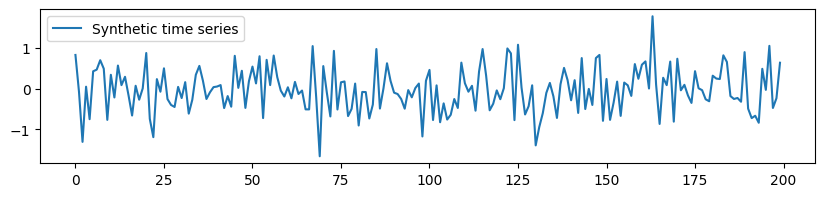

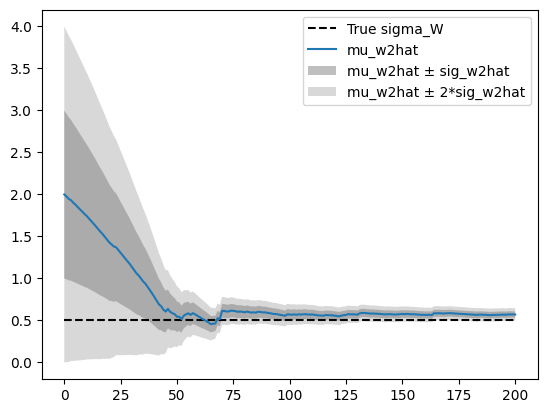

In [1]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM')

import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats as stats
from src.RL_functions.generate_synthetic_time_series import *

components = ['level', 'ar']
hyperparameters = {'level': {'process_error_var': 0.0},
                   'ar': {'phi': 0., 'process_error_var': 0.5**2},
                #    'ar': {'phi': 0.75, 'process_error_var': 0**2},
                   'observation': {'error': 1e-20}}
x_init = {'mu': np.array([0,  -0.05]), \
          'var': np.diag([1E-15, 6.36E-05])}

total_time_steps = int(200)
time_step_interval = 1
np.random.seed(2024)

syn_ts = generate_time_series(components = components,\
                                      time_step = time_step_interval, \
                                      hyperparameters = hyperparameters,\
                                      num_steps = total_time_steps, \
                                      x_init = x_init,\
                                      insert_anomaly = False)

from matplotlib import gridspec
fig = plt.figure(figsize=(10, 2))
gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])

ax0.plot(syn_ts['timesteps'], syn_ts['y'], label='Synthetic time series', alpha=1)
ax0.legend()


truesig = 0.5
N=200

#initials
mu_w2hat = 2**2
sig_w2hat = 1**2

sauv=[[np.sqrt(mu_w2hat),np.sqrt(sig_w2hat)]]

for n in range(N):
    # New observation ( W|y)
    mu_wy           = syn_ts['y'][n] # mu_{t|t}^{W}
    sig_wy          = 0
    # Equations 2.10 (Approximation of W^2)
    mu_w2y          = mu_wy**2 + sig_wy
    sig_w2y         = 2*sig_wy**2 + 4 * sig_wy*mu_wy**2
    # Equations 2.11 (Transition of W^2)
    mu_w2           = mu_w2hat     # mu_{t|t-1}^{W2}
    cov_w2          = 3*sig_w2hat + 2*mu_w2hat**2
    print(mu_w2)
    print(cov_w2)
    print(mu_w2y)
    print(sig_w2y)

    # Equations 2.12 (Update of \overline{W^2})
    Ktw              = sig_w2hat/cov_w2
    mu_w2hat        = mu_w2hat + Ktw*(mu_w2y - mu_w2) # mu_{t|t}^{V2hat}
    sig_w2hat       = sig_w2hat + Ktw**2*(sig_w2y - cov_w2)
    # Memoire
    sauv.append([np.sqrt(mu_w2hat),np.sqrt(sig_w2hat)])
    print(mu_w2hat)
    print(sig_w2hat)
    print('===========')


plt.figure()
sauv = np.array(sauv)
n = np.arange(0,N+1,1)
plt.plot(n,np.ones([N+1,1])*truesig, '--', color = 'black',label='True sigma_W' )
plt.plot(n,sauv[:,0],label='mu_w2hat' )
plt.fill_between(n, sauv[:,0]-sauv[:,1], sauv[:,0]+sauv[:,1], facecolor='gray',  alpha=0.5,label='mu_w2hat \u00B1 sig_w2hat')
plt.fill_between(n, sauv[:,0]-2*sauv[:,1], sauv[:,0]+2*sauv[:,1], facecolor='gray',  alpha=0.3,label='mu_w2hat \u00B1 2*sig_w2hat')
plt.legend()
plt.savefig('EstimeSigmaw.png', dpi=400,)